# Evaluation

## Imports

In [1]:
import datetime
import plotly.figure_factory as ff
import wandb
from matplotlib import pyplot as plt
import sklearn
import pytorch_lightning as pl
import flash
import flash.image
from flash.core.data.utils import download_data
import os
import glob
import pandas as pd
import sklearn.model_selection
import numpy as np
import torch
from torchvision import transforms as T
import flash
from flash.core.data.data_source import DefaultDataKeys
from flash.core.data.transforms import ApplyToKeys, merge_transforms
import flash.core.classification 
import warnings
import itertools
import timeit
import json
import torchinfo
import joblib
import matplotlib.image as mpimg
import torchvision
import PIL

In [2]:
import warnings

warnings.filterwarnings("ignore", message="Default upsampling behavior when mode=bilinear")

In [3]:
import utility


In [4]:
#import "01_train.py"

In [5]:
pl.seed_everything(99)

Global seed set to 99


99

In [6]:
!ls artifacts

classes.txt  data  label_encoder.joblib  metrics  model


In [7]:
!ls -lah artifacts/model

total 529M
drwxr-xr-x 3 jupyter jupyter 4.0K Nov  9 22:44 .
drwxr-xr-x 6 jupyter jupyter 4.0K Nov  9 14:41 ..
drwxr-xr-x 2 jupyter jupyter 4.0K Nov  8 14:35 .ipynb_checkpoints
-rw-r--r-- 1 jupyter jupyter  28M Nov  9 20:05 model_mobilenet_v2.pt
-rw-r--r-- 1 jupyter jupyter 272M Nov  9 21:06 model_resnet50.pt
-rw-r--r-- 1 jupyter jupyter 230M Nov  9 22:44 model_vgg19.pt


## Utility Functions

In [8]:
def load_model(model_name:str):
    artifact_model_path = f"{artifact_dir}/model/model_{model_name}.pt"

    model = flash.image.ImageClassifier.load_from_checkpoint(artifact_model_path)   
    return model


def time_inference(model,sample_image:str, device='cpu'):
    model = model.eval()
    #sample_image_tensor = torchvision.io.read_image(sample_image)


    with torch.no_grad():
        convert_tensor = torchvision.transforms.ToTensor()
        image_tensor = convert_tensor(PIL.Image.open(sample_image))
        model = model.to(device)
        image_tensor = image_tensor.to(device)
        predictions = model(image_tensor)
        
#         model = model.to(device)
#         #sample_image_tensor = sample_image_tensor.to(device)
#         predictions = model.predict(sample_image)
#         #predictions = model(sample_image_tensor)


def compute_metrics(model,trainer,datamodule , df_eval:pd.DataFrame, labels, num_iterations=10):
    
    metrics_test = trainer.test(model, datamodule=datamodule)
    metrics_val  = trainer.validate(model, datamodule=datamodule)
    
    eval_accuracy, (y_proba,y_pred,y_true) = utility.evaluate_model(model,df_eval,trainer)
    
    sample_image = df_eval['file_path'].iloc[0]
    
    time_gpu = timeit.timeit(lambda: time_inference (model,sample_image, device='cuda:0') ,number=num_iterations   ) 
    time_cpu = timeit.timeit(lambda: time_inference (model,sample_image,device='cpu') ,number=num_iterations   ) 
    
    model_summary = torchinfo.summary(model, input_size=sample_input_size, verbose=0)
    
    
    
    
    
    metrics = {**metrics_test[0], **metrics_val[0]}

    metrics['eval_accuracy'] = eval_accuracy



    metrics['inference_time_cpu'] = time_cpu / num_iterations
    metrics['inference_time_gpu'] = time_gpu / num_iterations
    
    metrics['params_total'] = model_summary.total_params
    
    
    disp = visualize_metrics(y_proba,y_pred,y_true,labels)
    plt.figure()
    #plt.imshow(disp)
    
    return metrics 


def visualize_metrics(y_proba,y_pred,y_true,cm_labels):
    # https://stackoverflow.com/questions/60860121/plotly-how-to-make-an-annotated-confusion-matrix-using-a-heatmap
    
    print ( sklearn.metrics.classification_report(y_true, y_pred, target_names=labels) )
    
    
    fig, ax = plt.subplots(figsize=(50,50))
    
    
    disp = sklearn.metrics.ConfusionMatrixDisplay.from_predictions(
        y_true=y_true, y_pred = y_pred ,
        #normalize = 'true',
        display_labels=cm_labels,
        xticks_rotation='vertical',
        ax=ax
    )
    disp

## Setup

In [9]:
artifact_dir="artifacts"


In [10]:
new_transforms = utility.image_transforms()

        
df_train = pd.read_parquet(f"{artifact_dir}/data/df_train.parquet" )
df_test = pd.read_parquet(f"{artifact_dir}/data/df_test.parquet")
df_val = pd.read_parquet(f"{artifact_dir}/data/df_val.parquet")
df_eval = pd.read_parquet(f"{artifact_dir}/data/df_eval.parquet")
    
    


In [11]:
datamodule = flash.image.ImageClassificationData.from_data_frame(
        "file_path",
        "label",
        train_data_frame=df_train,
        val_data_frame=df_val,
        test_data_frame=df_test,
        train_transform=new_transforms,
        batch_size=64,
        num_workers=16
)

/opt/conda/envs/pt/lib/python3.8/site-packages/flash/core/data/data_source.py:575: UserWarning: Using default resolver, this may take a while.
  warnings.warn("Using default resolver, this may take a while.", UserWarning)
Resolving files: 100%|██████████| 51509/51509 [04:08<00:00, 206.91it/s]
/opt/conda/envs/pt/lib/python3.8/site-packages/flash/core/data/data_source.py:575: UserWarning: Using default resolver, this may take a while.
  warnings.warn("Using default resolver, this may take a while.", UserWarning)
Resolving files: 100%|██████████| 12878/12878 [00:45<00:00, 284.66it/s]
/opt/conda/envs/pt/lib/python3.8/site-packages/flash/core/data/data_source.py:575: UserWarning: Using default resolver, this may take a while.
  warnings.warn("Using default resolver, this may take a while.", UserWarning)
Resolving files: 100%|██████████| 11363/11363 [00:36<00:00, 313.56it/s]


In [12]:
label_encoder = joblib.load(f'{artifact_dir}/label_encoder.joblib')
labels = label_encoder.classes_

In [13]:
sample_input_size = (1, 3, 224, 224)


In [14]:
sample_image = df_eval['file_path'].iloc[0]

In [15]:
trainer = flash.Trainer(gpus=[0])


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


## Model : vgg19

In [16]:
model_name="vgg19"
model = load_model(model_name)


Using 'vgg19' provided by PyTorch/torchvision (https://github.com/pytorch/vision).


In [17]:
model

ImageClassifier(
  (train_metrics): ModuleDict(
    (accuracy): Accuracy()
  )
  (val_metrics): ModuleDict(
    (accuracy): Accuracy()
  )
  (test_metrics): ModuleDict(
    (accuracy): Accuracy()
  )
  (adapter): DefaultAdapter(
    (backbone): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, k

/opt/conda/envs/pt/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:173: LightningDeprecationWarning: Method `on_test_dataloader` is deprecated in v1.5.0 and will be removed in v1.7.0. Please use `test_dataloader()` directly.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 0it [00:00, ?it/s]

/opt/conda/envs/pt/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:56: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/opt/conda/envs/pt/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:56: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 35. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/opt/conda/envs/pt/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:173: LightningDeprecationWarning: Method `on_val_dataloader` is deprecated in v1.5.0 and will be removed in v1.7.0. Please use `val_dataloader()` directly.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.6589809060096741, 'test_cross_entropy': 1.3896287679672241}
--------------------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

/opt/conda/envs/pt/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:56: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 14. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/opt/conda/envs/pt/lib/python3.8/site-packages/flash/core/data/data_source.py:575: UserWarning: Using default resolver, this may take a while.
  warnings.warn("Using default resolver, this may take a while.", UserWarning)


--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_accuracy': 0.6613604426383972, 'val_cross_entropy': 1.390676736831665}
--------------------------------------------------------------------------------


Resolving files: 100%|██████████| 25250/25250 [00:33<00:00, 762.60it/s]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/opt/conda/envs/pt/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:173: LightningDeprecationWarning: Method `on_predict_dataloader` is deprecated in v1.5.0 and will be removed in v1.7.0. Please use `predict_dataloader()` directly.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

                         precision    recall  f1-score   support

              apple_pie       0.50      0.38      0.43       250
         baby_back_ribs       0.75      0.74      0.74       250
                baklava       0.72      0.84      0.77       250
         beef_carpaccio       0.85      0.73      0.79       250
           beef_tartare       0.55      0.81      0.66       250
             beet_salad       0.63      0.68      0.65       250
               beignets       0.75      0.84      0.80       250
               bibimbap       0.98      0.75      0.85       250
          bread_pudding       0.54      0.51      0.53       250
      breakfast_burrito       0.80      0.43      0.56       250
             bruschetta       0.77      0.52      0.62       250
           caesar_salad       0.78      0.82      0.80       250
                cannoli       0.59      0.86      0.70       250
          caprese_salad       0.80      0.70      0.74       250
            carrot_cake 

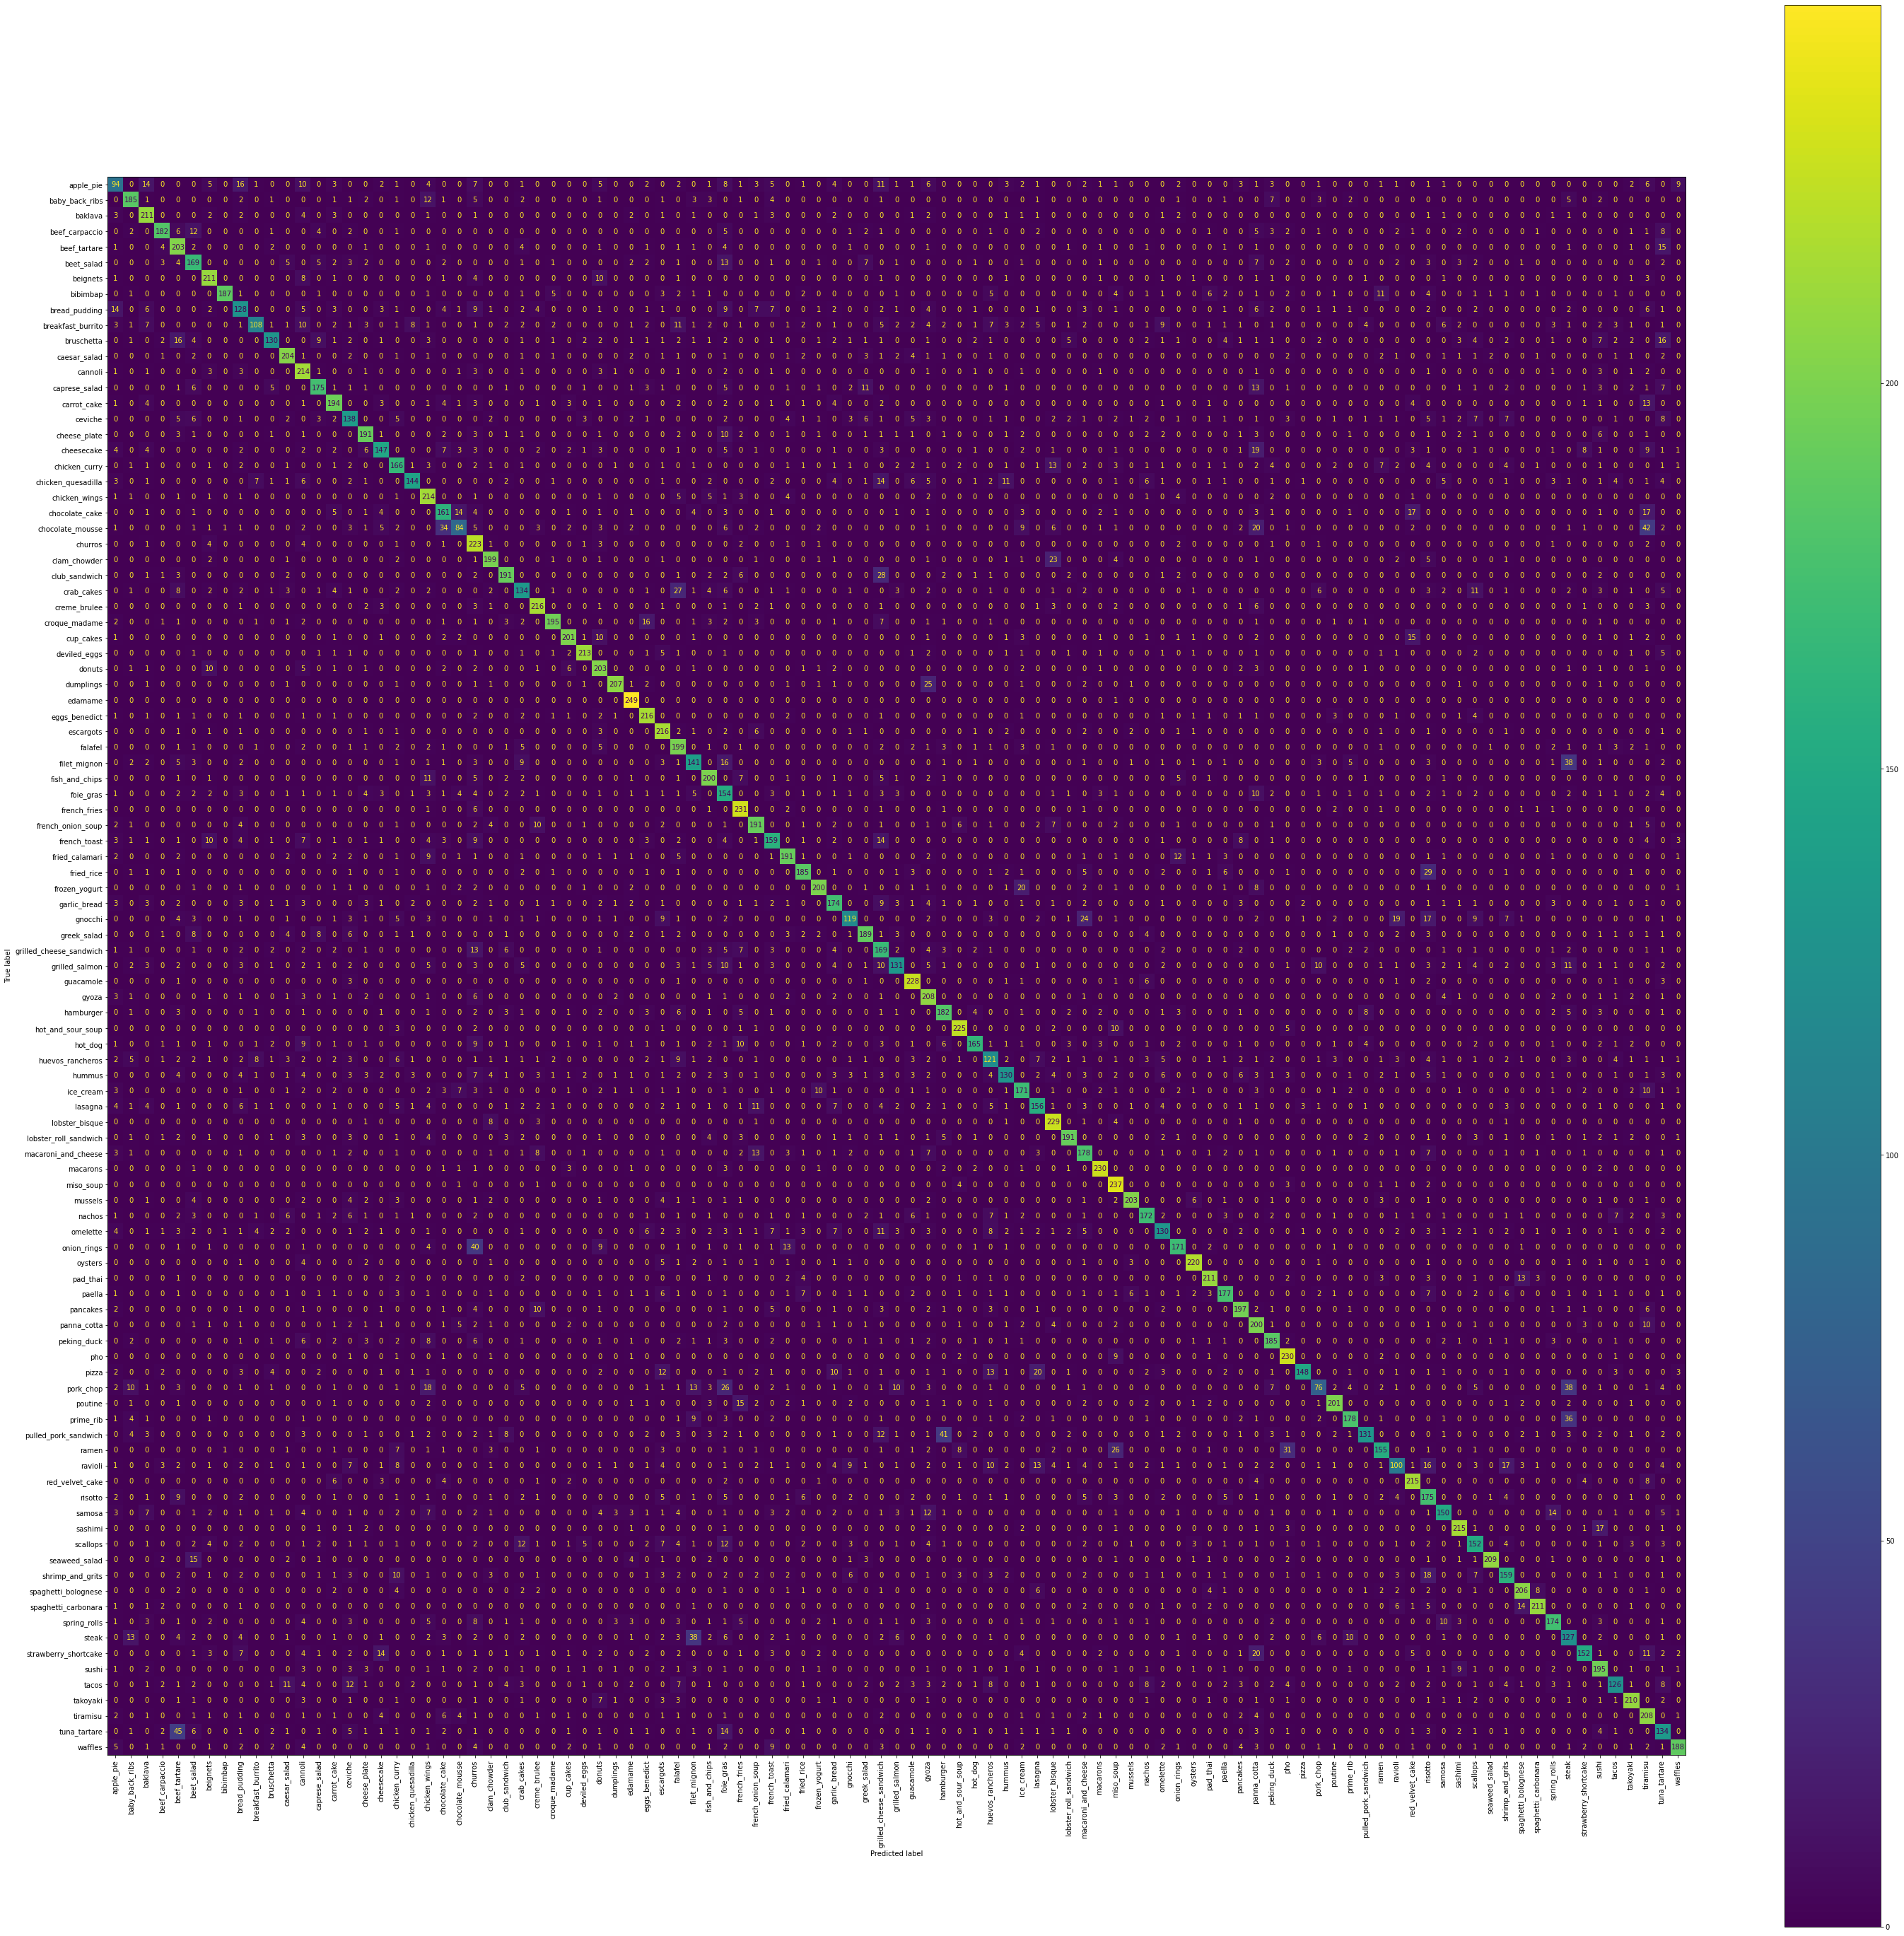

<Figure size 432x288 with 0 Axes>

In [18]:
metrics  = compute_metrics(model,trainer,datamodule ,df_eval, labels)

In [19]:
metrics

{'test_accuracy': 0.6589809060096741,
 'test_cross_entropy': 1.3896287679672241,
 'val_accuracy': 0.6613604426383972,
 'val_cross_entropy': 1.390676736831665,
 'eval_accuracy': 0.7159603960396039,
 'inference_time_cpu': 0.6471291871988797,
 'inference_time_gpu': 0.050848626600054556,
 'params_total': 20076197}

In [20]:
model = load_model(model_name)

Using 'vgg19' provided by PyTorch/torchvision (https://github.com/pytorch/vision).


In [21]:
%%timeit -r 5 -n 10
time_inference (model,sample_image, device='cuda:0') 

40.4 ms ± 1.43 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)


In [22]:
%%timeit -r 5 -n 10
time_inference (model,sample_image, device='cpu')

638 ms ± 17.8 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)


## Model: ResNet50

In [23]:
model_name = "resnet50"
model = load_model(model_name)
model

ImageClassifier(
  (train_metrics): ModuleDict(
    (accuracy): Accuracy()
  )
  (val_metrics): ModuleDict(
    (accuracy): Accuracy()
  )
  (test_metrics): ModuleDict(
    (accuracy): Accuracy()
  )
  (adapter): DefaultAdapter(
    (backbone): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (c

/opt/conda/envs/pt/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:173: LightningDeprecationWarning: Method `on_test_dataloader` is deprecated in v1.5.0 and will be removed in v1.7.0. Please use `test_dataloader()` directly.
  rank_zero_deprecation(
/opt/conda/envs/pt/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 0it [00:00, ?it/s]

/opt/conda/envs/pt/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(
/opt/conda/envs/pt/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:173: LightningDeprecationWarning: Method `on_val_dataloader` is deprecated in v1.5.0 and will be removed in v1.7.0. Please use `val_dataloader()` directly.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.6956789493560791, 'test_cross_entropy': 1.245164394378662}
--------------------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_accuracy': 0.6969249844551086, 'val_cross_entropy': 1.2186437845230103}
--------------------------------------------------------------------------------


/opt/conda/envs/pt/lib/python3.8/site-packages/flash/core/data/data_source.py:575: UserWarning: Using default resolver, this may take a while.
  warnings.warn("Using default resolver, this may take a while.", UserWarning)
Resolving files: 100%|██████████| 25250/25250 [00:33<00:00, 744.99it/s]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/opt/conda/envs/pt/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:173: LightningDeprecationWarning: Method `on_predict_dataloader` is deprecated in v1.5.0 and will be removed in v1.7.0. Please use `predict_dataloader()` directly.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

                         precision    recall  f1-score   support

              apple_pie       0.77      0.30      0.43       250
         baby_back_ribs       0.62      0.85      0.72       250
                baklava       0.80      0.84      0.82       250
         beef_carpaccio       0.76      0.81      0.79       250
           beef_tartare       0.64      0.82      0.72       250
             beet_salad       0.58      0.75      0.65       250
               beignets       0.57      0.94      0.71       250
               bibimbap       0.92      0.85      0.88       250
          bread_pudding       0.71      0.39      0.50       250
      breakfast_burrito       0.57      0.77      0.66       250
             bruschetta       0.47      0.77      0.59       250
           caesar_salad       0.75      0.88      0.81       250
                cannoli       0.81      0.82      0.81       250
          caprese_salad       0.56      0.88      0.69       250
            carrot_cake 

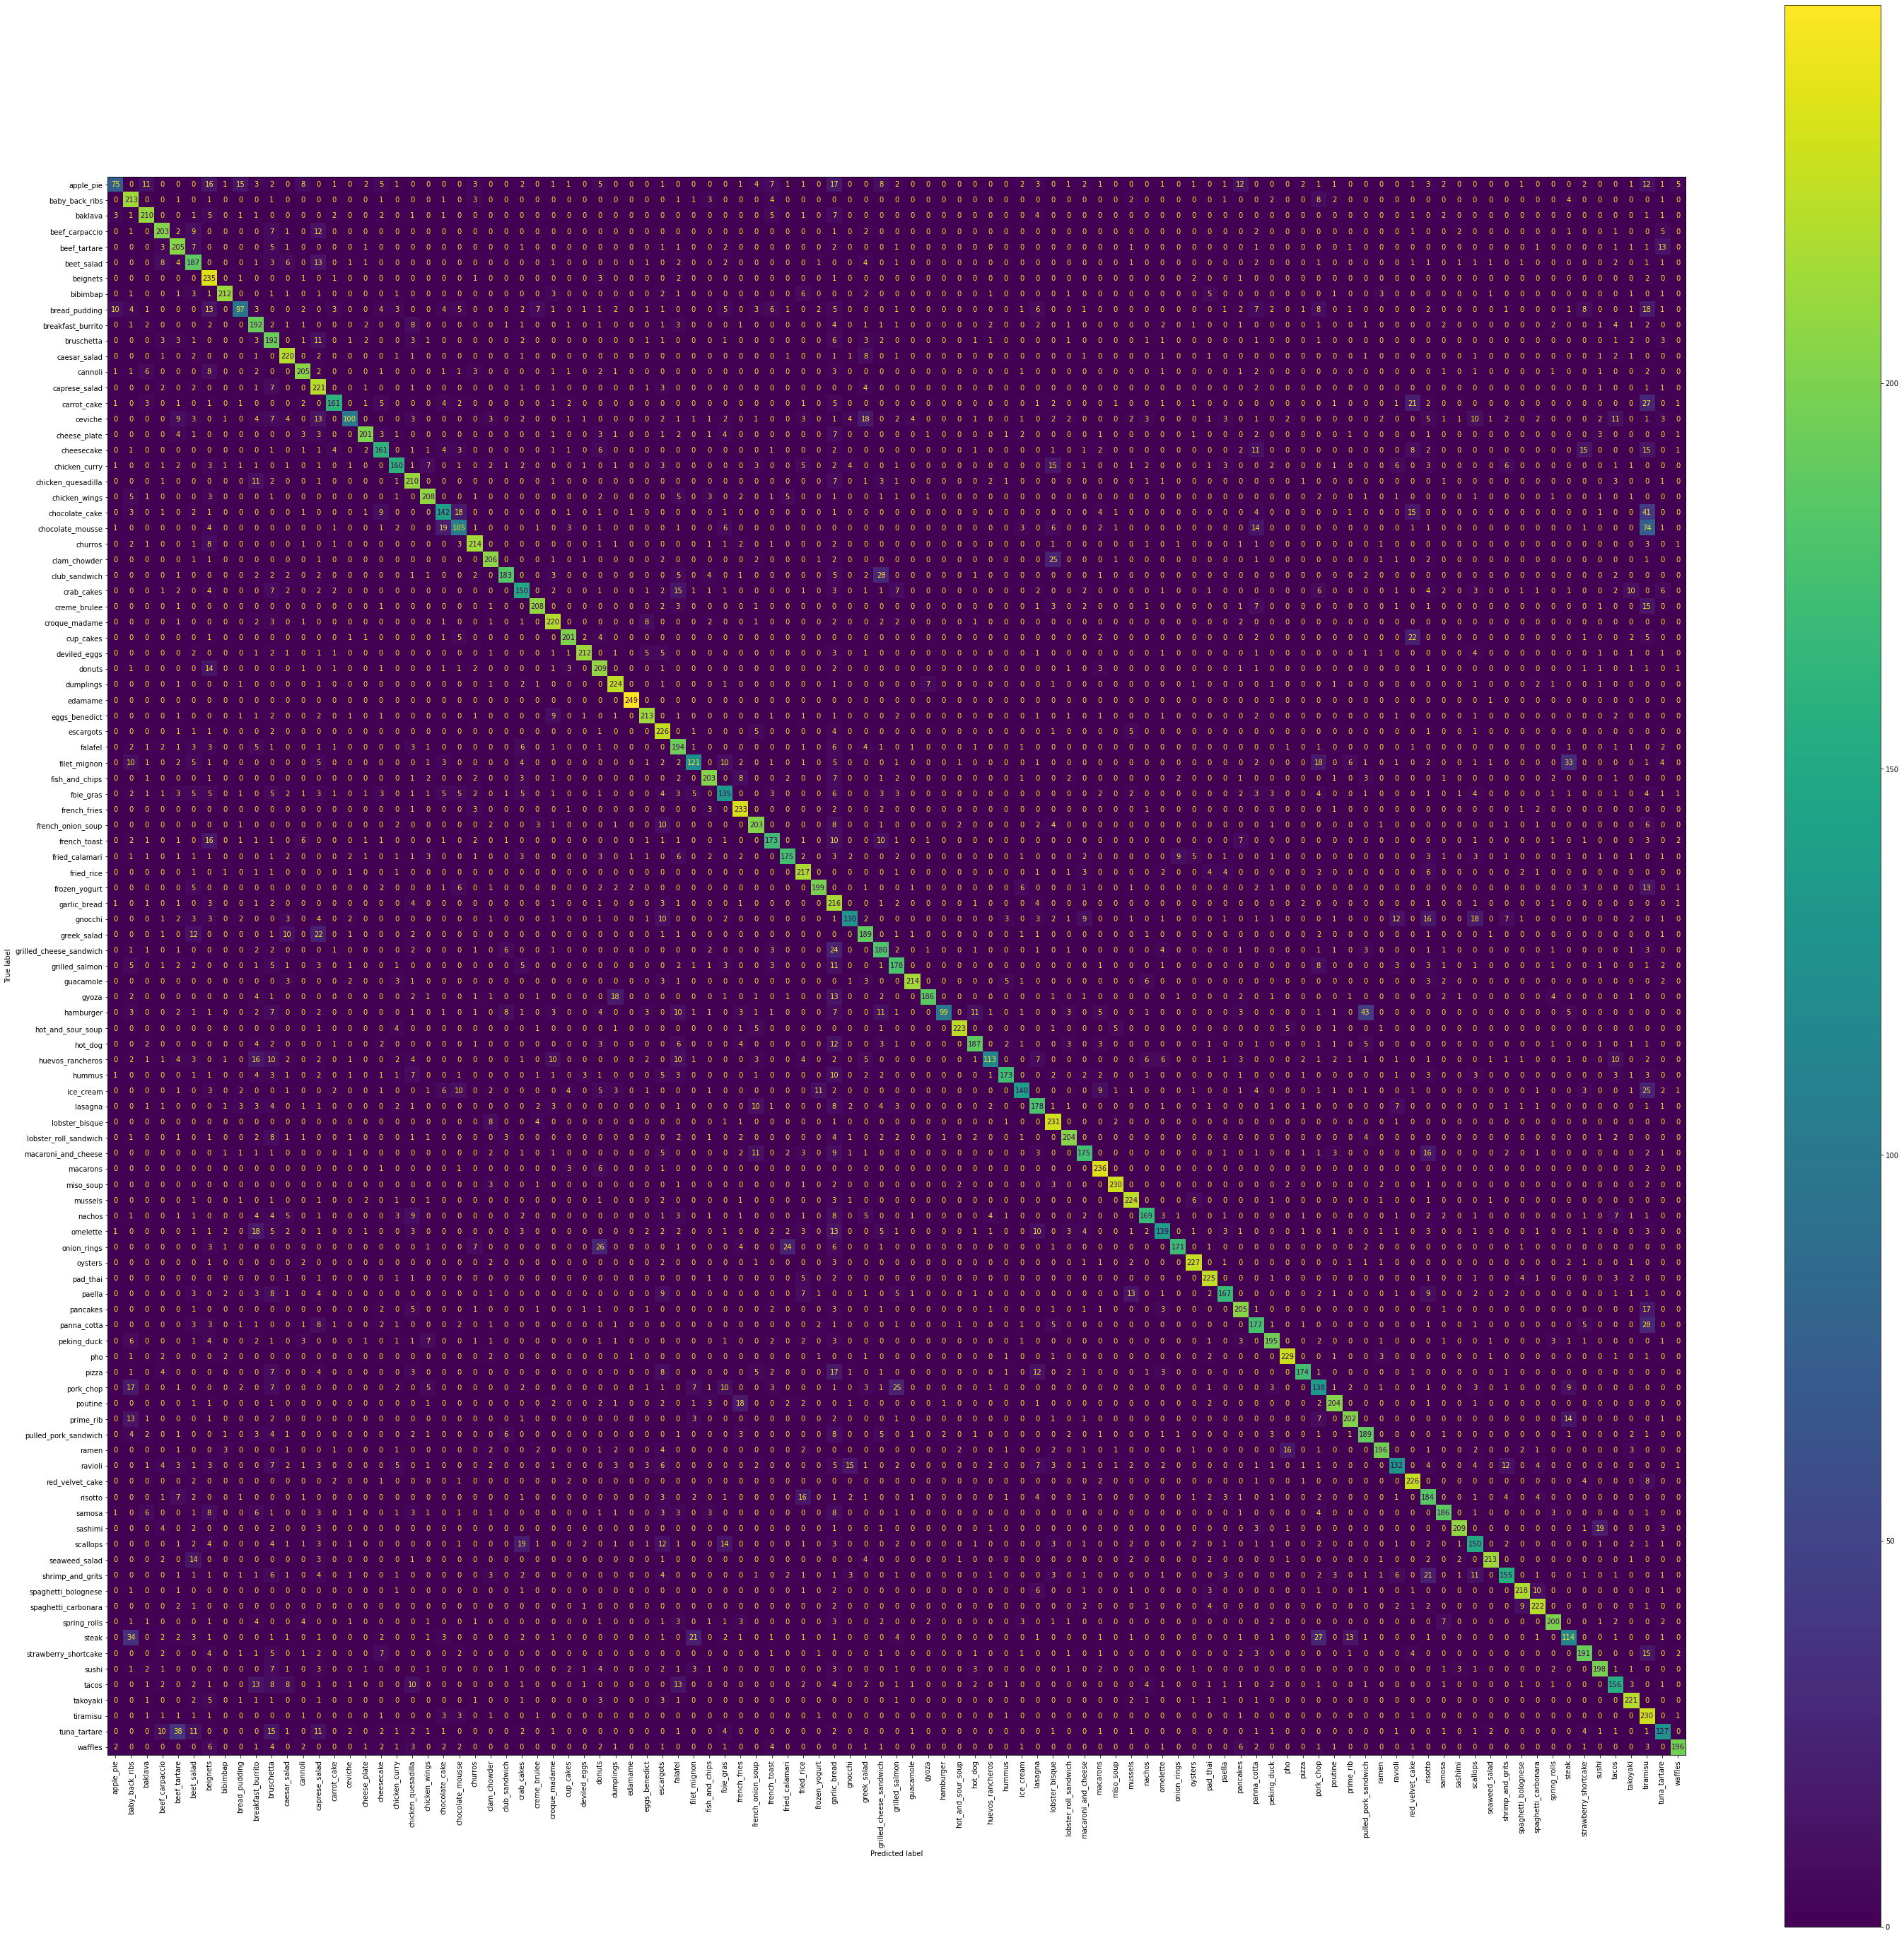

<Figure size 432x288 with 0 Axes>

In [24]:
metrics  = compute_metrics(model,trainer,datamodule ,df_eval, labels)

In [25]:
metrics

{'test_accuracy': 0.6956789493560791,
 'test_cross_entropy': 1.245164394378662,
 'val_accuracy': 0.6969249844551086,
 'val_cross_entropy': 1.2186437845230103,
 'eval_accuracy': 0.7494653465346535,
 'inference_time_cpu': 0.19064849360001973,
 'inference_time_gpu': 0.020389324199641123,
 'params_total': 23714981}

In [26]:
model = load_model(model_name)

In [27]:
%%timeit -r 5 -n 10
time_inference (model,sample_image, device='cuda:0') 

20 ms ± 3.87 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)


In [28]:
%%timeit -r 5 -n 10
time_inference (model,sample_image, device='cpu') 

184 ms ± 3.62 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)


## Model: mobilenet_v2

In [29]:
model_name = "mobilenet_v2"
model = load_model("mobilenet_v2")
model

Using 'mobilenet_v2' provided by PyTorch/torchvision (https://github.com/pytorch/vision).


ImageClassifier(
  (train_metrics): ModuleDict(
    (accuracy): Accuracy()
  )
  (val_metrics): ModuleDict(
    (accuracy): Accuracy()
  )
  (test_metrics): ModuleDict(
    (accuracy): Accuracy()
  )
  (adapter): DefaultAdapter(
    (backbone): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True

/opt/conda/envs/pt/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:173: LightningDeprecationWarning: Method `on_test_dataloader` is deprecated in v1.5.0 and will be removed in v1.7.0. Please use `test_dataloader()` directly.
  rank_zero_deprecation(
/opt/conda/envs/pt/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 0it [00:00, ?it/s]

/opt/conda/envs/pt/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(
/opt/conda/envs/pt/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:173: LightningDeprecationWarning: Method `on_val_dataloader` is deprecated in v1.5.0 and will be removed in v1.7.0. Please use `val_dataloader()` directly.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.6818621754646301, 'test_cross_entropy': 1.2596737146377563}
--------------------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

/opt/conda/envs/pt/lib/python3.8/site-packages/flash/core/data/data_source.py:575: UserWarning: Using default resolver, this may take a while.
  warnings.warn("Using default resolver, this may take a while.", UserWarning)


--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_accuracy': 0.690324604511261, 'val_cross_entropy': 1.238555908203125}
--------------------------------------------------------------------------------


Resolving files: 100%|██████████| 25250/25250 [00:33<00:00, 747.30it/s]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/opt/conda/envs/pt/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:173: LightningDeprecationWarning: Method `on_predict_dataloader` is deprecated in v1.5.0 and will be removed in v1.7.0. Please use `predict_dataloader()` directly.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

                         precision    recall  f1-score   support

              apple_pie       0.48      0.50      0.49       250
         baby_back_ribs       0.67      0.80      0.73       250
                baklava       0.70      0.87      0.78       250
         beef_carpaccio       0.77      0.84      0.81       250
           beef_tartare       0.50      0.83      0.62       250
             beet_salad       0.60      0.68      0.64       250
               beignets       0.76      0.89      0.82       250
               bibimbap       0.90      0.88      0.89       250
          bread_pudding       0.50      0.53      0.51       250
      breakfast_burrito       0.64      0.57      0.60       250
             bruschetta       0.63      0.70      0.66       250
           caesar_salad       0.71      0.86      0.78       250
                cannoli       0.77      0.84      0.81       250
          caprese_salad       0.71      0.72      0.72       250
            carrot_cake 

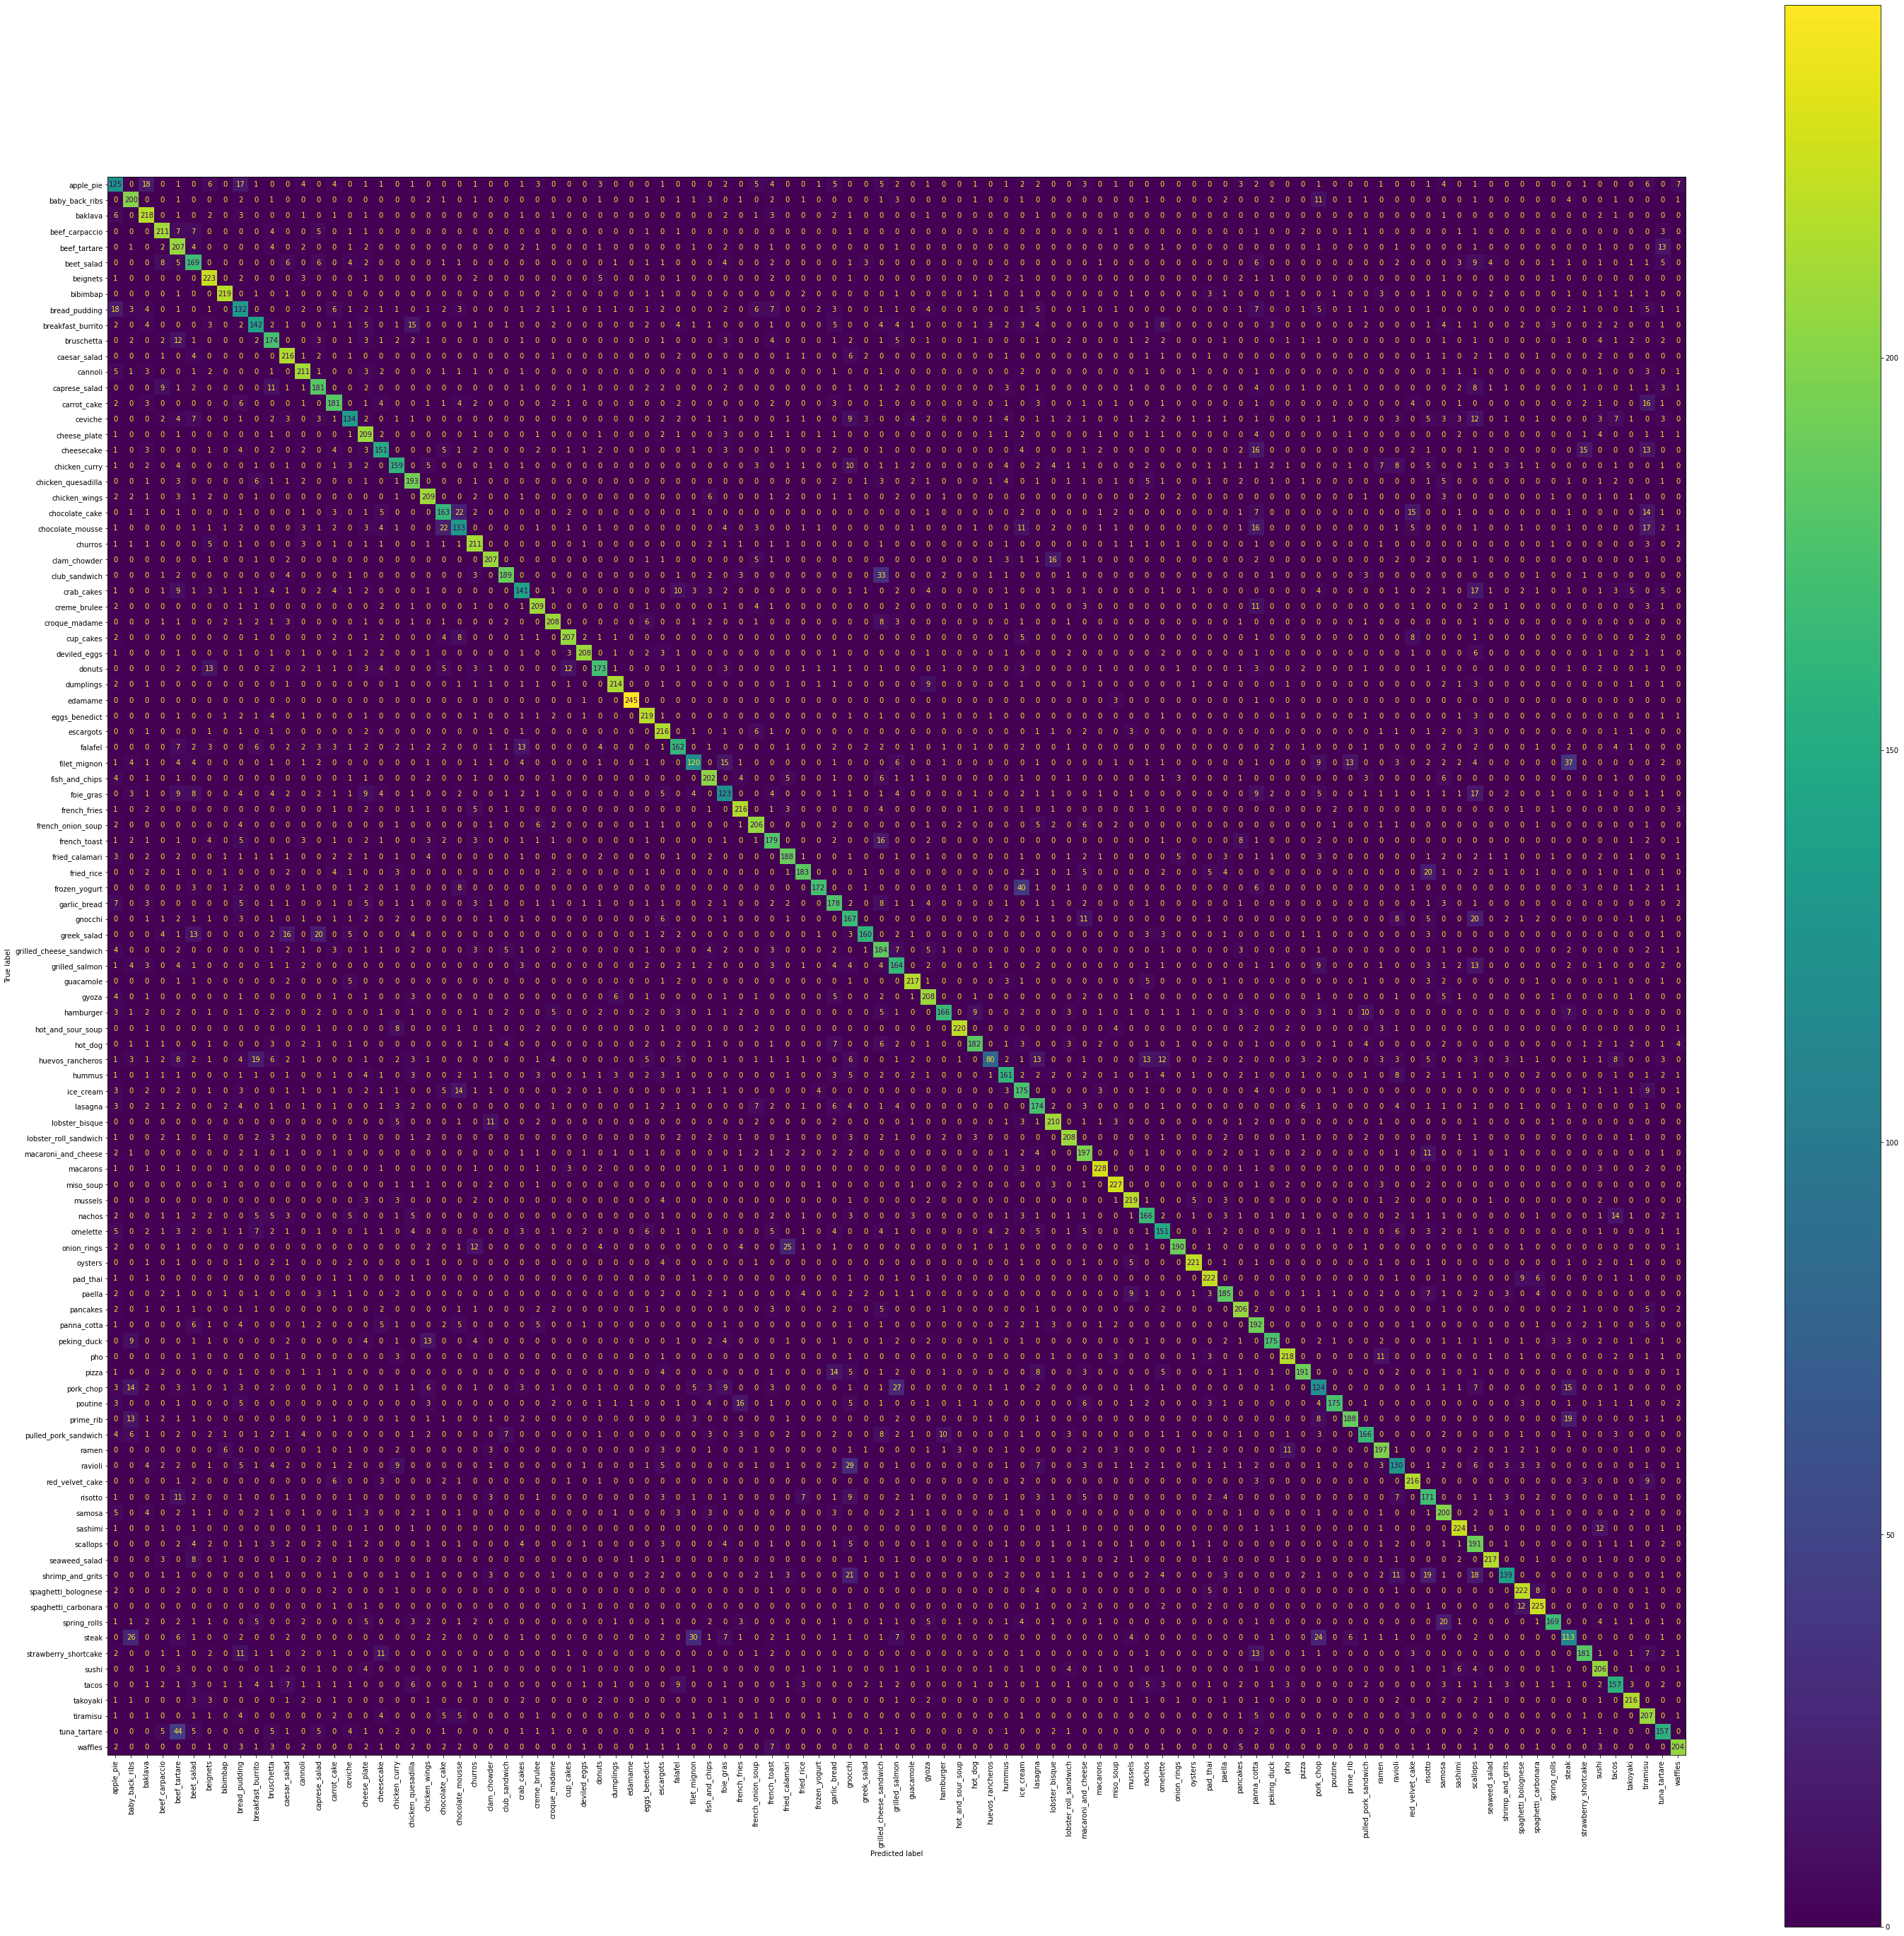

<Figure size 432x288 with 0 Axes>

In [30]:
metrics  = compute_metrics(model,trainer,datamodule ,df_eval, labels)

In [31]:
metrics

{'test_accuracy': 0.6818621754646301,
 'test_cross_entropy': 1.2596737146377563,
 'val_accuracy': 0.690324604511261,
 'val_cross_entropy': 1.238555908203125,
 'eval_accuracy': 0.7443564356435644,
 'inference_time_cpu': 0.04351627920113969,
 'inference_time_gpu': 0.013025704000028782,
 'params_total': 2353253}

In [32]:
model = load_model(model_name)

Using 'mobilenet_v2' provided by PyTorch/torchvision (https://github.com/pytorch/vision).


In [33]:
%%timeit -r 5 -n 10
time_inference (model,sample_image, device='cuda:0') 

12.4 ms ± 675 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)


In [34]:
%%timeit -r 5 -n 10
time_inference (model,sample_image, device='cpu') 

41 ms ± 1.42 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)


## Sample Image

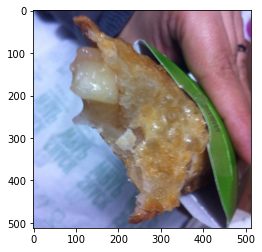

In [35]:
sample_image_path = df_eval['file_path'].iloc[0]
image = mpimg.imread(sample_image_path)
plt.imshow(image)

In [38]:
model.serializer = flash.core.classification.Probabilities()
predictions = model.predict(sample_image_path)
sorted ( zip (label_encoder.classes_, predictions[0]), key= lambda x:x[1] ,reverse =True)[:5]

[('apple_pie', 0.6515036821365356),
 ('samosa', 0.1864335685968399),
 ('churros', 0.07538770139217377),
 ('baklava', 0.028286099433898926),
 ('frozen_yogurt', 0.01116786990314722)]

In [37]:
predictions[0]

0


| Model  | Params|  Accuracy | Time(cpu) |Time(gpu) | Model Size [b]
|-------:|------:|----------:|-------:| -----:| -----:|
| VGG19| 20,076,197   |  71.5% | 638 | 40 | 230MB
| ResNet50| 23,714,981   |  74.9% | 184 | 20 | 272MB
| MobileNetV2| 2,353,253   |  74.4% | 41 | 12.4 | 28MB

